<a href="https://colab.research.google.com/github/andrepaim/spelling_bee/blob/main/text2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/ai-forever/diffusers.git
!pip install transformers
!pip install accelerate

In [ ]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

DEVICE = torch.device('cuda:0')

In [ ]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    subfolder='image_encoder'
).half().to(DEVICE)

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder',
    subfolder='unet'
).half().to(DEVICE)

In [ ]:
prior = KandinskyV22PriorPipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    image_encoder=image_encoder,
    torch_dtype=torch.float16
).to(DEVICE)

text_encoder/model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
decoder = KandinskyV22Pipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder',
    unet=unet,
    torch_dtype=torch.float16
).to(DEVICE)

movq/diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
torch.manual_seed(42)

negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'
img_emb = prior(
    prompt='They danced the polka',
    num_inference_steps=25,
    num_images_per_prompt=1
)

negative_emb = prior(
    prompt=negative_prior_prompt,
    num_inference_steps=25,
    num_images_per_prompt=1
)


images = decoder(
    image_embeds=img_emb.image_embeds,
    negative_image_embeds=negative_emb.image_embeds,
    num_inference_steps=75,
    height=512,
    width=512)

  0%|          | 0/25 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature']


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

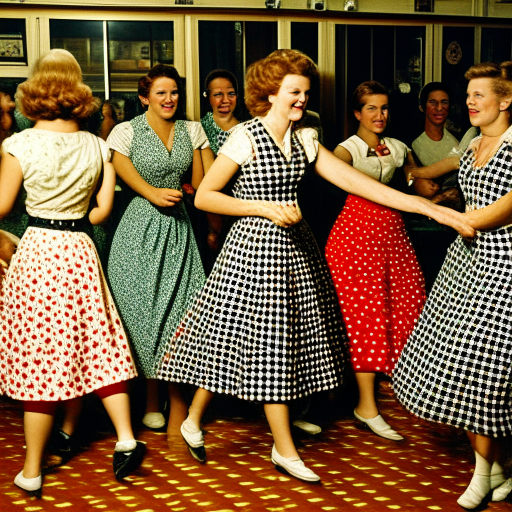

In [19]:
images.images[0]